<a href="https://colab.research.google.com/github/Riccardo-Vecchi/Pytorch-Quaternion-Neural-Networks/blob/master/quaternion_nn_experiments.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Presentation 

**Goal:** Test several compression techniques for Quaternion Neural Networks (from new forms of regularization to Deep compression).

**Datasets:**
 - MNIST    http://yann.lecun.com/exdb/mnist/
 - CIFAR10  https://www.cs.toronto.edu/~kriz/cifar.html


 **Inspiring papers:**   
  - Group Sparse Regularization for Deep Neural Networks 
     - https://arxiv.org/pdf/1607.00485.pdf
  - Deep Compression: Compressing Deep Neural Networks with Pruning, Trained Quantization and Huffman Coding
     - https://arxiv.org/pdf/1510.00149.pdf
  - MorphNet: Fast & Simple Resource-Constrained Structure Learning of Deep Networks
     - https://arxiv.org/pdf/1711.06798.pdf

**Author:** Riccardo Vecchi

**Version:** 1.0

---

#Guide

1.   Clone the repository in the Colab's runtime with the "Clone repository" cell
2.   Use forms for setting parameters and hyper-parameters and run experiments
3.   Good testing :-)




# Manage repository

## Clone repository

In [1]:
!git clone https://github.com/eretis/Pytorch-Quaternion-Neural-Networks.git

Cloning into 'Pytorch-Quaternion-Neural-Networks'...
remote: Enumerating objects: 341, done.
remote: Total 341 (delta 0), reused 0 (delta 0), pack-reused 341
Receiving objects: 100% (341/341), 2.64 MiB | 15.63 MiB/s, done.
Resolving deltas: 100% (199/199), done.


## Refresh repository

In [0]:
!cd /content/Pytorch-Quaternion-Neural-Networks && git pull

## Delete repository

In [0]:
!rm -rf Pytorch-Quaternion-Neural-Networks

# Experiments

##Import all needed library and set the environment

In [0]:
%cd /content/Pytorch-Quaternion-Neural-Networks 

import torch.optim as optim

import torchvision
from torchvision.datasets import MNIST, CIFAR10 

from models.convolutional_models import *

from sklearn.cluster import KMeans
from scipy.interpolate import splrep, splev

from skimage.measure import compare_ssim as ssim
from utils.misc import *
import imageio

import matplotlib.pyplot as plt

import re, time, gzip

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

CIFAR10_num_to_classes = ('airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

colors = ('green', 'blue', 'red', 'black', 'darkviolet', 'brown', 'darkorange', 'deepskyblue', 'darkcyan', 'pink')
plt.rcParams['axes.grid'] = True


def get_dataset():
  
    print('Retrieve ' + dataset.__name__ + ' dataset...\n')

    if dataset == CIFAR10:
        transform = torchvision.transforms.Compose([torchvision.transforms.ToTensor(),
                                                    torchvision.transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
    else:
        transform = torchvision.transforms.Compose([torchvision.transforms.ToTensor(), 
                                                    torchvision.transforms.Normalize((0.1307,), (0.3081,))])  # global mean and standard deviation for MNIST

    train_loader = torch.utils.data.DataLoader(
        dataset('/files/', train=True, download=True, transform=transform), batch_size=batch_size_train, shuffle=True, num_workers=4)

    test_loader = torch.utils.data.DataLoader(
        dataset('/files/', train=False, download=True, transform=transform), batch_size=batch_size_test, shuffle=True, num_workers=4)

    return train_loader, test_loader


def count_trainable_parameters():
    return sum(p.numel() for p in network.parameters() if p.requires_grad) 
  
  
def regularization(reg_type=None):

    reg = 0
    
    if reg_type == 'L1':
      for param in network.parameters():
        reg = reg + torch.sum(torch.abs(param))    
        
    elif reg_type == 'L1_gamma':
      for module in network.modules():
        if isinstance(module, QuaternionBatchNorm2d):
          reg = reg + torch.sum(torch.abs(module.gamma))
      
    elif reg_type == 'L1_without_gamma':
      for module in network.modules():
        if not isinstance(module, QuaternionBatchNorm2d):
          for param in module.parameters(recurse=False):
            reg = reg + torch.sum(torch.abs(param))
                 
    elif reg_type == 'L2':
      for param in network.parameters():
        reg = reg + torch.sum(param**2)

    elif reg_type == 'RQ': # 'Group L1'
        for module in network.modules():
          if isinstance(module, (QuaternionConv, QuaternionLinear, QuaternionTransposeConv)):
            reg = reg + torch.sum(torch.sqrt(module.r_weight**2 + module.i_weight**2 + module.j_weight**2 + module.k_weight**2))
            
    elif reg_type == 'RQL': # 'Sparse GL1'
      reg = reg + regularization('RQ') + regularization('L1')
        
    elif reg_type == 'RQL_without_gamma':
        reg = reg + regularization('RQ') + regularization('L1_without_gamma')
        
    return reg


def compute_and_print_sparsity(decimals=3, experiment_name=None, writer=None):

    network.eval()
  
    nonzero_weights, nonzero_quaternions, number_of_quaternions, gamma_ratio = 0, 0, 0, 1.
    number_of_neurons = 0
    nonzero_neurons = 0
    
    for module in network.modules():
      
        if isinstance(module, QuaternionBatchNorm2d):
          zero_gamma = torch.le(torch.abs(module.gamma), 10**(-decimals))  # number of gamma that are 0
          gamma_ratio *= (zero_gamma.numel() - torch.sum(zero_gamma).item())/zero_gamma.numel() if zero_gamma is not None else 1.
          zero_gamma = None
          
        for param in module.parameters(recurse=False):       
          nonzero_weights += torch.sum(torch.ge(torch.abs(param.detach()), 10**(-decimals))).item() * gamma_ratio
                       
        if isinstance(module, (QuaternionConv, QuaternionLinear, QuaternionTransposeConv)):
          number_of_quaternions += module.r_weight.numel()
          number_of_neurons += module.r_weight.shape[1]
          quat_norm = torch.sqrt(module.r_weight**2 + module.i_weight**2 + module.j_weight**2 + module.k_weight**2)          
          nonzero_quaternions += torch.sum(torch.ge(torch.abs(quat_norm), 10**(-decimals))).item() * gamma_ratio

          #aaa = torch.abs(module.r_weight + module.i_weight + module.j_weight + module.k_weight)
          #bbb = torch.le(torch.sum(aaa), 10**(-decimals))
          #print(bbb)
          #nonzero_neurons += torch.sum(bbb) * gamma_ratio
          
    weight_sparsity = (1 - nonzero_weights / count_trainable_parameters()) * 100
    quaternion_sparsity = (1 - nonzero_quaternions / number_of_quaternions) * 100 if use_quaternion_variant else 0
    #neuron_sparsity = (1 - nonzero_neurons / number_of_neurons) * 100 
    
    if experiment_name is not None:
      experiments_results[experiment_name]['weight'].append(weight_sparsity)
      experiments_results[experiment_name]['quaternion'].append(quaternion_sparsity)
      #experiments_results[experiment_name]['neuron'].append(neuron_sparsity)

    print('Checking sparsity...\nWeight sparsity: {:.2f}%'.format(weight_sparsity))
    print('Quaternion sparsity: {:.2f}%\n'.format(quaternion_sparsity)) if use_quaternion_variant else print()
    #print('Neuron sparsity: {:.2f}%\n'.format(neuron_sparsity))
    
    if use_tensorboard and writer is not None:
      writer.add_scalars('Sparsity', { 'Weight sparsity [%]' : weight_sparsity,
                                       'Quaternion sparsity [%]' : quaternion_sparsity }, globaliter)
    

def expand_input(data, expansion='rgb_vector'):  # [BATCH X CHANNELS X WIDTH X HEIGHT]

    if expansion == 'repeat':  # Copy the original input also for vector components (i, j, k)
        new_input = np.repeat(data, 4, axis=1)

    elif expansion == 'zero_vector':  # Zero-fill for vector components (i, j, k)
        new_input = torch.zeros(data.shape[0], 4, data.shape[2], data.shape[3], dtype=torch.float, device=device)
        new_input[:, :1, :, :] = data

    elif expansion == 'rgb_vector':  # Real part to 0 and vector part (i, j, k) <- RGB
        new_input = torch.zeros((data.shape[0], 4, data.shape[2], data.shape[3]), dtype=torch.float, device=device)
        new_input[:, 1:, :, :] = data

    return new_input
  
  
#def adjust_learning_rate(lr, optimizer, epoch):
#    """Sets the learning rate to the initial LR decayed by 10 every 30 epochs"""
#    learning_rt = lr * (0.1 ** (epoch // 30))
#    for param_group in optimizer.param_groups:
#        param_group['lr'] = learning_rt
        
def adjust_learning_rate(lr, epoch):
    """Sets the learning rate to the initial LR decayed by 10 every 30 epochs"""
    return lr * (0.1 ** (epoch // 30))
    #for param_group in optimizer.param_groups:
    #    param_group['lr'] = learning_rt
  

def prune(decimals=3):

  print('Pruning the network...\n')
  
  for param in network.parameters(): # with network.parameters(recurse=False) non mi entra nel ciclo :O

    weight_mask = torch.ge(torch.abs(param), 10**(-decimals)).type_as(param)
    param.detach().mul_(weight_mask)
    
    codebook['masks'].append(weight_mask)
    # param.data = param.to_sparse().coalesce() # feature requested in https://github.com/pytorch/pytorch/issues/16667
    
  # compute_and_print_sparsity() sono riuscito a rendere weight sparsity = anche dopo il pruning..c'è ancora qualche differenza con la quaternion, lascialo per testare
  

def apply_weight_sharing(bits=2):  # 2^bits possible weights per layer
  
  print('Applying weight sharing [{} bits]...'.format(bits))

  for param in network.parameters():

    weights = param.to('cpu').detach().numpy()
    nonzero_indices = np.nonzero(weights)
    k_means_input = weights[nonzero_indices]
    
    space = np.linspace(np.min(k_means_input), np.max(k_means_input), num=2**bits)
    k_means = KMeans(n_clusters=len(space), init=space.reshape(-1, 1), n_init=1)
    k_means.fit(k_means_input.reshape(-1, 1))
    weights[nonzero_indices] = k_means.cluster_centers_[k_means.labels_].reshape(-1)

    param.data = torch.from_numpy(weights).to(device)
    
    codebook['centroids'].append(torch.from_numpy(k_means.cluster_centers_).reshape(-1))
    codebook['labels'].append(torch.from_numpy(k_means.labels_).type(dtype=torch.LongTensor))

    
def apply_quaternion_weight_sharing(bits=3):  # 2^bits possible weights per quaternion layer
  
  print('Applying quaternion weight sharing [{} bits]...'.format(bits))

  for module in network.modules():
    
    if isinstance(module, (QuaternionConv, QuaternionLinear, QuaternionTransposeConv)):
      
      weights = np.array([], dtype=np.float32)   
      for param in module.parameters():
        if param.dim() == 1: # avoid biases if exist (one-dimensional arrays)
          continue
        weights = np.append(weights, param.reshape(-1).detach().to('cpu').numpy())
      
      nonzero_indices = np.nonzero(weights)
      k_means_input = weights[nonzero_indices]
    
      space = np.linspace(np.min(k_means_input), np.max(k_means_input), num=2**bits)
      k_means = KMeans(n_clusters=len(space), init=space.reshape(-1, 1), n_init=1)
      k_means.fit(k_means_input.reshape(-1, 1))
      weights[nonzero_indices] = k_means.cluster_centers_[k_means.labels_].reshape(-1)
    
      new_weights = np.split(weights, 4)
      
      for index, param in enumerate(module.parameters()):
        if param.dim() == 1: # avoid biases if exist (one-dimensional arrays)
          continue
        param.data = torch.from_numpy(new_weights[index]).reshape_as(param.data).to(device)
    
      codebook['centroids'].append(torch.from_numpy(k_means.cluster_centers_).reshape(-1))
      codebook['labels'].append(torch.from_numpy(k_means.labels_).type(dtype=torch.LongTensor))    
    
    
def fine_tuning_centroids(n_iter=30, learning_rate_tuning=0.0001):
  
  print('Fine tuning centroids...\n')
  
  # compute_and_print_sparsity() poi sale la sparsity....
  
  for iteration in range(n_iter):
    
    print('iteration [{}/{}]'.format(iteration+1, n_iter))
    
    for batch_index, (data, target) in enumerate(train_set):
      
      if use_quaternion_variant:
        data = expand_input(data, input_expansion)
        
      data, target = data.to(device), target.to(device)
      
      optimizer.zero_grad()
      output = network(data)  # Forward pass
      loss = loss_criterion(output, target)
      loss.backward()  # Backward pass
      
    for index, param in enumerate(network.parameters()):

      gradient = param.grad.reshape(-1)

      for centroid in range(codebook['centroids'][index].numel()):
        sum_of_gradients = 0

        for cluster in range(codebook['labels'][index].numel()):
          if codebook['labels'][index][cluster] == centroid:
            sum_of_gradients = sum_of_gradients + gradient[cluster]

        codebook['centroids'][index][centroid] -= learning_rate_tuning * sum_of_gradients
        
      new_weights = codebook['masks'][index].to('cpu').numpy()
      
      np.place(new_weights, new_weights, codebook['centroids'][index][codebook['labels'][index]])

      param.data = torch.from_numpy(new_weights).to(device)
    
    #learning_rate_tuning = adjust_learning_rate(learning_rate_tuning, optimizer, n_iter)
    #for param_group in optimizer.param_groups:
    #  print(param_group['lr'])
      
    test(n_epochs + n_iter)
  

def save_codebook():
  
  torch.set_printoptions(profile='full')
  
  codified_codebook = str(codebook).replace(' ', '').replace('tensor([', '$').replace(']),', '$').replace('$$', '$').replace('\n', '').replace("])],'labels':[", "$$").replace("{'centroids':[", "").replace('])]}', '')
  
  # print(codified_codebook)
  
  codebook_filename = '../' + network.network_type() + '_codebook'
  
  with open(codebook_filename, 'w') as file:
    file.write(codified_codebook)
    
  with gzip.open(codebook_filename + '.gz', 'wb') as file:
    file.write(codified_codebook.encode())

    
def load_codebook():
  
  codebook_filename = '../' + network.network_type() + '_codebook'
    
  with gzip.open(codebook_filename + '.gz', 'r') as file:
    stored_codebook = file.read().decode().split('$$')

    centroids = re.findall(r'\$([0-9+\-.,e]+)', stored_codebook[0])
    for centroid in centroids:
      centroid_ = [float(i) for i in centroid.split(',')]
      codebook['centroids'].append(torch.Tensor(centroid_))
      
    labels = re.findall(r'\$([0-9+\-.,e]+)', stored_codebook[1])
    for label in labels:
      label_ = [int(i) for i in label.split(',')]
      codebook['labels'].append(torch.LongTensor(label_))
      
  #print(codebook)
      
     
def train(experiment_name=None, writer=None):
  
    global globaliter
    
    print('\nStart training from ' + dataset.__name__ + ' training set to generate the model...')
    print('Epochs: ' + str(n_epochs) + '\nLearning rate: ' + str(learning_rate) + '\n')
    
    start_time = time.time()

    # TRAIN LOOP #
    for epoch in range(n_epochs):

        test(epoch, experiment_name, writer)
        compute_and_print_sparsity(experiment_name=experiment_name, writer=writer)
        network.train()

        for batch_index, (data, target) in enumerate(train_set):

            if use_quaternion_variant:
                data = expand_input(data, input_expansion)

            data, target = data.to(device), target.to(device)

            optimizer.zero_grad()
            output = network(data)  # Forward pass
            loss = loss_criterion(output, target)
            loss_with_reg = loss + regularization_factor * regularization(regularizer)
            loss_with_reg.backward()  # Backward pass
            
            optimizer.step()  # Optimize

            if batch_index % log_interval == 0:
                print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                    epoch + 1, batch_index * data.shape[0], len(train_set.dataset),
                    100. * batch_index / len(train_set), loss.item()))
                train_losses.append(loss_with_reg.item())
                train_counter.append((batch_index * batch_size_train) + (epoch * len(train_set.dataset)))
                
            if use_tensorboard and writer is not None:
              writer.add_scalar('Performance/Loss', loss.item(), globaliter)
                  
              for name, param in network.named_parameters():
                writer.add_histogram(name, param.clone().to('cpu').detach().numpy(), globaliter)

              for name, module in network.named_modules():
                if isinstance(module, (QuaternionConv, QuaternionLinear, QuaternionTransposeConv)):
                  quat_norm = torch.sqrt(module.r_weight**2 + module.i_weight**2 + module.j_weight**2 + module.k_weight**2)
                  writer.add_histogram(name +'_norm_'+regularizer, quat_norm, globaliter)
            
            globaliter += 1
    
    test(n_epochs, experiment_name, writer)
    compute_and_print_sparsity(experiment_name=experiment_name, writer=writer)
    print('Elapsed time: {:.2f} seconds\n'.format(time.time()-start_time))
    
        
def test(epoch, experiment_name=None, writer=None):
  
    network.eval()
  
    test_loss, correct = 0, 0
    
    with torch.no_grad():
      for data, target in test_set:

        if use_quaternion_variant:
          data = expand_input(data, input_expansion)

        data, target = data.to(device), target.to(device)

        output = network(data)
        test_loss += loss_criterion(output, target, reduction='sum').item()
        pred = output.detach().max(1, keepdim=True)[1]
        correct += pred.eq(target.detach().view_as(pred)).sum().item()
        
    test_loss /= len(test_set.dataset)
    test_losses.append(test_loss)
    
    accuracy = 100. * correct / len(test_set.dataset)
    
    if experiment_name is not None:
      experiments_results[experiment_name]['accuracy'].append(accuracy)
    test_counter.append(epoch * len(train_set.dataset))
    print('\nTest set: Avg. loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        test_loss, correct, len(test_set.dataset), accuracy))
    
    if use_tensorboard and writer is not None:
      writer.add_scalar('Performance/Accuracy', accuracy, epoch)

        
def inference(raw_image):
  
    image_tensor = raw_image.unsqueeze_(0).to(device)
    if use_quaternion_variant:
        image_tensor = expand_input(image_tensor, input_expansion)
    network.eval()
    output = network(image_tensor)
    index = torch.argmax(output).item()
    index = CIFAR10_num_to_classes[index] if dataset == CIFAR10 else index
    return index


def show_image(image, text_ground_truth):
    plt.tight_layout()
    plt.subplot(2, 3, 1)
    plt.xticks([])
    plt.yticks([])

    image = np.transpose(image / 2 + 0.5, (1, 2, 0)) if dataset == CIFAR10 else image[0]
    plt.imshow(image, cmap='gray', interpolation='nearest')

    text_ground_truth = CIFAR10_num_to_classes[text_ground_truth] if dataset == CIFAR10 else text_ground_truth
    plt.title('Ground Truth: {}'.format(text_ground_truth))
    plt.show()
    

def plot_training_curve():
    plt.plot(train_counter, train_losses, color='blue')
    plt.scatter(test_counter, test_losses, color='red')
    plt.legend(['Train Loss', 'Test Loss'], loc='upper right')
    plt.xlabel('Number of training examples seen')
    plt.ylabel(loss_criterion.__name__.capitalize().replace('_', ' '))
    plt.show()
    

def run_tensorboard_server():
  print('\nStarting Tensorboard server...')
  !pip install -qqq tensorboardX tensorboardcolab
  from tensorboardX import SummaryWriter
  from tensorboardcolab import TensorBoardColab
  TensorBoardColab()
  return SummaryWriter('Graph')


#def set_deterministic_environment(seed=1234):
#  torch.manual_seed(seed)
#  torch.cuda.manual_seed(seed)
#  torch.backends.cudnn.deterministic = True
  
    
def smooth_data(list_x, list_y, smooth=125):
  
  #bspl = splrep(list_x, list_y, s=smooth)
  #bspl_y = splev(list_x, bspl)
  
  #df = pd.DataFrame(list_y, columns=['a'])
  #df.ewm(halflife=6.).mean()
    
  return list_y #bspl_y
  

/content/Pytorch-Quaternion-Neural-Networks


## Test Quaternion vs Real-valued NNs

Device used: cuda
Network variant: CIFARConvNetA
Number of trainable parameters: 191414

Retrieve CIFAR10 dataset...

Files already downloaded and verified
Files already downloaded and verified

Start training from CIFAR10 training set to generate the model...
Epochs: 50
Learning rate: 0.002


Test set: Avg. loss: 2.3072, Accuracy: 1000/10000 (10.00%)

Checking sparsity...
Weight sparsity: 3.33%

Train Epoch: 1 [0/50000 (0%)]	Loss: 2.317948
Train Epoch: 1 [4000/50000 (8%)]	Loss: 2.231289
Train Epoch: 1 [8000/50000 (16%)]	Loss: 2.236071
Train Epoch: 1 [12000/50000 (24%)]	Loss: 2.173315
Train Epoch: 1 [16000/50000 (32%)]	Loss: 2.140582
Train Epoch: 1 [20000/50000 (40%)]	Loss: 2.149676
Train Epoch: 1 [24000/50000 (48%)]	Loss: 2.071027
Train Epoch: 1 [28000/50000 (56%)]	Loss: 2.049323
Train Epoch: 1 [32000/50000 (64%)]	Loss: 2.011396
Train Epoch: 1 [36000/50000 (72%)]	Loss: 2.052885
Train Epoch: 1 [40000/50000 (80%)]	Loss: 1.992829
Train Epoch: 1 [44000/50000 (88%)]	Loss: 2.062087
Train Ep

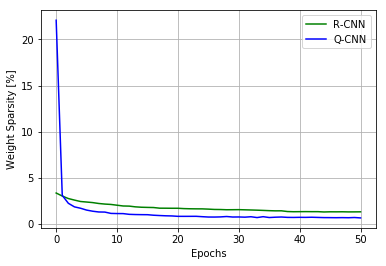

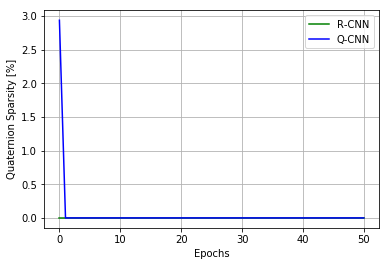

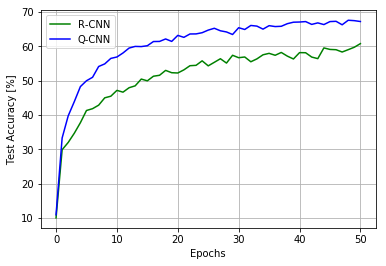

In [0]:
class CIFARConvNetA(nn.Module):  # Standard CNN for CIFAR-10

    def __init__(self):
        super(CIFARConvNetA, self).__init__()

        self.act_fn = F.relu

        self.conv1 = nn.Conv2d(3, 8, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(8, 16, kernel_size=3, stride=1, padding=1)
        self.conv2_drop1 = nn.Dropout2d()
        self.conv3 = nn.Conv2d(16, 24, kernel_size=3, stride=1, padding=1)
        self.conv4 = nn.Conv2d(24, 76, kernel_size=3, stride=1, padding=1)
        self.conv4_drop2 = nn.Dropout2d()
        self.conv5 = nn.Conv2d(76, 128, kernel_size=3, stride=1, padding=1)
        self.fc1 = nn.Linear(2048, 40)
        self.fc2 = nn.Linear(40, 10)

    def forward(self, x):
        x = self.act_fn(F.max_pool2d(self.conv1(x), 2))
        x = self.act_fn(F.max_pool2d(self.conv2_drop1(self.conv2(x)), 2))
        x = self.act_fn(self.conv3(x))
        x = self.act_fn(F.max_pool2d(self.conv4_drop2(self.conv4(x)), 2))
        x = self.act_fn(self.conv5(x))
        #print(x.shape)
        x = x.view(-1, 2048)
        x = self.act_fn(self.fc1(x))
        x = F.dropout(x, training=self.training)
        x = self.fc2(x)
        return F.log_softmax(x, dim=1)

    def network_type(self):
        return type(self).__name__
      
      
class CIFARQConvNetA(nn.Module):  # Quaternion CNN for CIFAR-10

    def __init__(self):
        super(CIFARQConvNetA, self).__init__()

        self.act_fn = F.relu

        self.conv1 = QuaternionConv(4, 16, kernel_size=3, stride=1, padding=1)
        self.conv2 = QuaternionConv(16, 32, kernel_size=3, stride=1, padding=1)
        self.conv2_drop1 = nn.Dropout2d()
        self.conv3 = QuaternionConv(32, 64, kernel_size=3, stride=1, padding=1)
        self.conv4 = QuaternionConv(64, 96, kernel_size=3, stride=1, padding=1)
        self.conv4_drop2 = nn.Dropout2d()
        self.conv5 = QuaternionConv(96, 128, kernel_size=3, stride=1, padding=1)

        self.fc1 = QuaternionLinear(2048, 40)

    def forward(self, x):
        x = self.act_fn(F.max_pool2d(self.conv1(x), 2))
        x = self.act_fn(F.max_pool2d(self.conv2_drop1(self.conv2(x)), 2))
        x = self.act_fn(self.conv3(x))
        x = self.act_fn(F.max_pool2d(self.conv4_drop2(self.conv4(x)), 2))
        x = self.act_fn(self.conv5(x))
        #print(x.shape)
        x = x.view(-1, 2048)
        x = self.act_fn(self.fc1(x))
        x = F.dropout(x, training=self.training)
        x = torch.reshape(x, (-1, 10, 4))
        x = torch.sum(torch.abs(x), dim=2)
        return F.log_softmax(x, dim=1)

    def network_type(self):
        return type(self).__name__


#@markdown ##Parameters and Hyper-parameters
n_epochs = 50 #@param {type: 'number'}
dataset = CIFAR10 #@param ["CIFAR10", "MNIST"] {type:"raw"}
learning_rate = 0.002 #@param {type: 'number'}
loss_criterion = F.cross_entropy #@param ["F.cross_entropy", "F.nll_loss"] {type:"raw"}
batch_size_train = 400 #@param {type: 'number'}
batch_size_test = 1000 #@param {type: 'number'}
use_tensorboard = False #@param {type:"boolean"}

log_interval = 10
globaliter = 0

#set_deterministic_environment()

input_expansion = 'zero_vector' if dataset == MNIST else 'rgb_vector'
regularizer = 'None'
regularization_factor = 0.

train_counter, train_losses, test_counter, test_losses = [], [], [], []

writer = run_tensorboard_server() if use_tensorboard else None

experiments = {
    'R-CNN' : { 'network': MNISTConvNet() if dataset == MNIST else CIFARConvNetA() },
    'Q-CNN' : { 'network': MNISTQConvNet() if dataset == MNIST else CIFARQConvNetA() }
}

experiments_results = {
  'R-CNN' : { 'accuracy' : [], 'weight' : [], 'quaternion' : [] },
  'Q-CNN' : { 'accuracy' : [], 'weight' : [], 'quaternion' : [] },
}

plot1, ax1 = plt.subplots()
plot2, ax2 = plt.subplots()
plot3, ax3 = plt.subplots()
epoch_counter = list(range(n_epochs+1))
for index, (experiment_name, experiment_params) in enumerate(experiments.items()):
  
  use_quaternion_variant = True if experiment_name == 'Q-CNN' else False
  
  network = experiment_params['network']
  network = network.to(device)
  optimizer = optim.Adam(network.parameters(), lr=learning_rate)
  
  print('Device used: ' + device.type)
  print('Network variant: ' + network.network_type())
  print('Number of trainable parameters: {}\n'.format(count_trainable_parameters()))
  
  train_set, test_set = get_dataset()
  
  train(experiment_name, writer)
  
  print(experiment_name + ' weight')
  print(experiments_results[experiment_name]['weight'])
  print(experiment_name + ' quaternion')
  print(experiments_results[experiment_name]['quaternion'])
  print(experiment_name + ' accuracy')
  print(experiments_results[experiment_name]['accuracy'])
  
  ax1.plot(epoch_counter, smooth_data(test_counter, experiments_results[experiment_name]['weight']), color=colors[index])
  ax2.plot(epoch_counter, smooth_data(test_counter, experiments_results[experiment_name]['quaternion']), color=colors[index])
  ax3.plot(epoch_counter, smooth_data(test_counter, experiments_results[experiment_name]['accuracy']), color=colors[index]) 

  
ax1.legend(experiments.keys(), loc='best')
ax2.legend(experiments.keys(), loc='best')
ax3.legend(experiments.keys(), loc='best')
ax1.set(xlabel='Epochs', ylabel='Weight Sparsity [%]')
ax2.set(xlabel='Epochs', ylabel='Quaternion Sparsity [%]')
ax3.set(xlabel='Epochs', ylabel='Test Accuracy [%]')
plt.show()


## Test Regularization functions on Quaternion Networks

In [0]:
#@markdown ##Parameters and Hyper-parameters
n_epochs = 50 #@param {type: 'number'}
dataset = CIFAR10 #@param ["CIFAR10", "MNIST"] {type:"raw"}
use_quaternion_variant = True #@param {type: 'boolean'}
learning_rate = 0.002 #@param {type: 'number'}
loss_criterion = F.cross_entropy #@param ["F.cross_entropy", "F.nll_loss"] {type:"raw"}
batch_size_train = 400 #@param {type: 'number'}
batch_size_test = 1000 #@param {type: 'number'}
use_tensorboard = False #@param {type:"boolean"}

log_interval = 10
globaliter = 0

#set_deterministic_environment()

input_expansion = 'zero_vector' if dataset == MNIST else 'rgb_vector'

train_counter, train_losses, test_counter, test_losses = [], [], [], []

writer = run_tensorboard_server() if use_tensorboard else None

regularization_experiments = {
    #'None' : { 'reg_factor' : 0., 'latex_legend' : r'No reg.' },
    #'L1'   : { 'reg_factor' : 0.003  if dataset == MNIST else 0.000002, 'latex_legend' : r'$L_1$' },
    #'L2'   : { 'reg_factor' : 0.2    if dataset == MNIST else 0.00005, 'latex_legend' : r'$L_2$' },
    #'RQ'   : { 'reg_factor' : 0.0075  if dataset == MNIST else 0.0000053, 'latex_legend' : r'$R_Q$' },
    'RQL'   : { 'reg_factor' : 0.0027  if dataset == MNIST else 0.0000034, 'latex_legend' : r'$R_{QL}$' }
    
}

experiments_results = {
  'None' : { 'accuracy' : [], 'weight' : [], 'quaternion' : [], 'neuron' : [] },
  'L1'   : { 'accuracy' : [], 'weight' : [], 'quaternion' : [], 'neuron' : [] },
  'L2'   : { 'accuracy' : [], 'weight' : [], 'quaternion' : [], 'neuron' : [] },
  'RQ'   : { 'accuracy' : [], 'weight' : [], 'quaternion' : [], 'neuron' : [] },
  'RQL'  : { 'accuracy' : [], 'weight' : [], 'quaternion' : [], 'neuron' : [] },
}



plot1, ax1 = plt.subplots()
plot2, ax2 = plt.subplots()
plot3, ax3 = plt.subplots()
plot4, ax4 = plt.subplots()
for index, (experiment_name, experiment_params) in enumerate(regularization_experiments.items()):
  
  regularizer = experiment_name
  regularization_factor = experiment_params['reg_factor']
  
  print('\nRegularizer: {} Reg. factor: {} '.format(experiment_name, regularization_factor))
  
  if dataset == MNIST:
    network = MNISTQConvNet() if use_quaternion_variant else MNISTConvNet()
  else:
    network = CIFARQConvNet() if use_quaternion_variant else CIFARConvNet()
  
  network = network.to(device)
  optimizer = optim.Adam(network.parameters(), lr=learning_rate)
  
  print('Device used: ' + device.type)
  print('Network variant: ' + network.network_type())
  print('Number of trainable parameters: {}\n'.format(count_trainable_parameters()))
  
  test_counter = []
  
  train_set, test_set = get_dataset()
  
  train(experiment_name, writer)
  
  print(experiment_name + ' weight')
  print(experiments_results[experiment_name]['weight'])
  print(experiment_name + ' quaternion')
  print(experiments_results[experiment_name]['quaternion'])
  print(experiment_name + ' accuracy')
  print(experiments_results[experiment_name]['accuracy'])
        
  
  ax1.plot(test_counter, smooth_data(test_counter, experiments_results[experiment_name]['weight']), color=colors[index])
  ax2.plot(test_counter, smooth_data(test_counter, experiments_results[experiment_name]['quaternion']), color=colors[index])
  ax3.plot(test_counter, smooth_data(test_counter, experiments_results[experiment_name]['accuracy']), color=colors[index])
  ax4.plot(test_counter, smooth_data(test_counter, experiments_results[experiment_name]['neuron']), color=colors[index])

labels = [item['latex_legend'] for item in regularization_experiments.values()] 
  
ax1.legend(labels, loc='best')
ax2.legend(labels, loc='best')
ax3.legend(labels, loc='best')
ax4.legend(labels, loc='best')
ax1.set(xlabel='Number of training examples seen', ylabel='Weight Sparsity [%]')
ax2.set(xlabel='Number of training examples seen', ylabel='Quaternion Sparsity [%]')
ax3.set(xlabel='Number of training examples seen', ylabel='Test Accuracy [%]')
ax4.set(xlabel='Number of training examples seen', ylabel='Neuron Sparsity [%]')
plt.show()



NameError: ignored

In [0]:
#@markdown ##Parameters and Hyper-parameters
n_epochs = 1001 #@param {type: 'number'}
learning_rate = 0.002 #@param {type: 'number'}
use_quaternion_variant = True #@param {type: 'boolean'}
generation_rate = 100  # One test picture will be generated every 'generation_rate'
use_tensorboard = False #@param {type:"boolean"}

globaliter = 0
  
writer = run_tensorboard_server() if use_tensorboard else None

# MANAGING PICTURES #
empty_directory('RES')

train = rgb2gray(imageio.imread('KODAK/kodim05.png'), True)
test = imageio.imread('KODAK/kodim23.png')

# Normalizing
train = train / 255
test = test / 255

if use_quaternion_variant:

    # Add a 0 as real component if quaternions (padding)
    npad = ((0, 0), (0, 0), (1, 0))
    train = np.pad(train, pad_width=npad, mode='constant', constant_values=0)
    test = np.pad(test, pad_width=npad, mode='constant', constant_values=0)

# Channel first
train = np.transpose(train, (2, 0, 1))
test = np.transpose(test, (2, 0, 1))

# Add batch_size dim
train = np.reshape(train, (1, train.shape[0], train.shape[1], train.shape[2]))
test = np.reshape(test, (1, test.shape[0], test.shape[1], test.shape[2]))

train = torch.from_numpy(train).float().to(device)
test = torch.from_numpy(test).float().to(device)

regularization_experiments = {
    'None' : { 'reg_factor' : 0.0,     'latex_legend' : r'No reg.'  },
    'L1'   : { 'reg_factor' : 0.0001,  'latex_legend' : r'$L_1$'    },
    'L2'   : { 'reg_factor' : 0.005,   'latex_legend' : r'$L_2$'    },
    'RQ'   : { 'reg_factor' : 0.0003,  'latex_legend' : r'$R_Q$'    },
    'RQL'  : { 'reg_factor' : 0.00015, 'latex_legend' : r'$R_{QL}$' }
}

experiments_results = {
    'None' : { 'PSNR': [], 'SSIM': [], 'weight': [], 'quaternion': [] },
    'L1'   : { 'PSNR': [], 'SSIM': [], 'weight': [], 'quaternion': [] },
    'L2'   : { 'PSNR': [], 'SSIM': [], 'weight': [], 'quaternion': [] },
    'RQ'   : { 'PSNR': [], 'SSIM': [], 'weight': [], 'quaternion': [] },
    'RQL'  : { 'PSNR': [], 'SSIM': [], 'weight': [], 'quaternion': [] },
}

plot1, ax1 = plt.subplots()
plot2, ax2 = plt.subplots()
plot3, ax3 = plt.subplots()
plot4, ax4 = plt.subplots()

original = imageio.imread('KODAK/kodim23.png')

for index, (experiment_name, experiment_params) in enumerate(regularization_experiments.items()):

    regularizer = experiment_name
    regularization_factor = experiment_params['reg_factor']
    test_counter = []

    print('Regularizer: {} Reg. factor: {} '.format(experiment_name, regularization_factor))

    network = QCAE().to(device) if use_quaternion_variant else CAE().to(device)
    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(network.parameters(), lr=learning_rate)

    print('Device used: ' + device.type)
    print('Network variant: ' + network.network_type())
    print('Number of trainable parameters: {}\n'.format(count_trainable_parameters()))

    start_time = time.time()

    for epoch in range(n_epochs):

        globaliter += 1
        test_counter.append(epoch)
        compute_and_print_sparsity(experiment_name=experiment_name)

        output = network(train)
        loss = criterion(output, train) + regularization_factor * regularization(regularizer)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # If generation rate, generate a test image
        if (epoch % generation_rate) == 0:
            print("It : " + str(epoch + 1) + " | loss_train " + str(loss.to('cpu').detach().numpy()))
            output = network(test)
            out = output.to('cpu').detach().numpy()
            
            out = np.transpose(out, (0, 2, 3, 1))[:, :, :, 1:] if use_quaternion_variant else np.transpose(out, (0, 2, 3, 1))
            out = np.reshape(out, (out.shape[1], out.shape[2], out.shape[3]))

            imageio.imsave('RES/save_image' + str(epoch) + experiment_name + '.png', out)
            string_test = 'RES/save_image' + str(epoch) + experiment_name + '.png'
            contrast = imageio.imread(string_test)
            psnr_value = psnr(original, contrast)
            ssim_value = ssim(original, contrast, multichannel=True)
            print('PSNR: {}\nSSIM: {}'.format(psnr_value, ssim_value))
            experiments_results[experiment_name]['PSNR'].append(psnr_value)
            experiments_results[experiment_name]['SSIM'].append(ssim_value)

    compute_and_print_sparsity(experiment_name=experiment_name)
    test_counter.append(n_epochs)
    print('Elapsed time: {:.2f} seconds\n'.format(time.time() - start_time))
    
    print(experiment_name + ' weight')
    print(experiments_results[experiment_name]['weight'])
    print(experiment_name + ' quaternion')
    print(experiments_results[experiment_name]['quaternion'])
    print(experiment_name + ' PSNR')
    print(experiments_results[experiment_name]['PSNR'])
    print(experiment_name + ' SSIM')
    print(experiments_results[experiment_name]['SSIM'])
    
    ax1.plot(test_counter, smooth_data(test_counter, experiments_results[experiment_name]['weight']), color=colors[index])
    ax2.plot(test_counter, smooth_data(test_counter, experiments_results[experiment_name]['quaternion']), color=colors[index])
    ax3.plot(test_counter[::generation_rate], smooth_data(test_counter[::generation_rate], experiments_results[experiment_name]['PSNR']), color=colors[index])
    ax4.plot(test_counter[::generation_rate], smooth_data(test_counter[::generation_rate], experiments_results[experiment_name]['SSIM']), color=colors[index])

labels = [item['latex_legend'] for item in regularization_experiments.values()] 
    
ax1.legend(labels, loc='best')
ax2.legend(labels, loc='best')
ax3.legend(labels, loc='best')
ax4.legend(labels, loc='best')
ax1.set(xlabel='Number of training examples seen', ylabel='Weight Sparsity [%]')
ax2.set(xlabel='Number of training examples seen', ylabel='Quaternion Sparsity [%]')
ax3.set(xlabel='Number of training examples seen', ylabel='PSNR')
ax4.set(xlabel='Number of training examples seen', ylabel='SSIM')
plt.show()

## Test Quaternion Batch Normalization 

In [0]:
#@markdown ##Parameters and Hyper-parameters
n_epochs = 3 #@param {type: 'number'}
dataset = CIFAR10 #@param ["CIFAR10", "MNIST"] {type:"raw"}
learning_rate = 0.001 #@param {type: 'number'}
loss_criterion = F.cross_entropy #@param ["F.cross_entropy", "F.nll_loss"] {type:"raw"}
batch_size_train = 400 #@param {type: 'number'}
batch_size_test = 1000 #@param {type: 'number'}
use_tensorboard = False #@param {type:"boolean"}
regularization_factor = 0.000003 #@param {type: 'number'}
regularizer = 'None' #@param ['None', 'L1', 'L2', 'RQ', 'RQL']

use_quaternion_variant = True

log_interval = 10
globaliter = 0 

input_expansion = 'zero_vector' if dataset == MNIST else 'rgb_vector'

train_counter, train_losses, test_counter, test_losses = [], [], [], []

writer = run_tensorboard_server() if use_tensorboard else None

batch_norm_experiments = {
  'QCNN'       : { 'network': MNISTQConvNet() if dataset == MNIST else CIFARQConvNet() },
  'QCNN + BN'  : { 'network': MNISTQConvNetBN(False) if dataset == MNIST else CIFARQConvNetBN(False) },
  'QCNN + QBN' : { 'network': MNISTQConvNetBN(True) if dataset == MNIST else CIFARQConvNetBN(True) }
}

experiments_results = {
  'QCNN'       : { 'accuracy' : [], 'weight' : [], 'quaternion' : [] },
  'QCNN + BN'  : { 'accuracy' : [], 'weight' : [], 'quaternion' : [] },
  'QCNN + QBN' : { 'accuracy' : [], 'weight' : [], 'quaternion' : [] }
}


for index, (experiment_name, experiment_params) in enumerate(batch_norm_experiments.items()):

  print('Experiment: ' + experiment_name)
  
  network = experiment_params['network']
  
  network = network.to(device)
  optimizer = optim.Adam(network.parameters(), lr=learning_rate)
  
  print('Device used: ' + device.type)
  print('Network variant: ' + network.network_type())
  print('Number of trainable parameters: {}\n'.format(count_trainable_parameters()))
  
  test_counter = []
  
  train_set, test_set = get_dataset()
  
  train(experiment_name, writer)
  
  plt.plot(test_counter, experiments_results[experiment_name]['accuracy'], color=colors[index])  

plt.legend(batch_norm_experiments.keys(), loc='best')
plt.xlabel('Number of training examples seen')
plt.ylabel('Accuracy')
plt.show()


####1.   L1(gamma) vs RQ
####2.   L1(w+gamma) vs RQL

0it [00:00, ?it/s]


Regularizer: L1(gamma) Reg. factor: 2.5 
Device used: cuda
Network variant: MNISTQConvNetBNA
Number of trainable parameters: 11748

Retrieve MNIST dataset...



9920512it [00:01, 6630285.54it/s]                             


Extracting /files/MNIST/raw/train-images-idx3-ubyte.gz


32768it [00:00, 321513.43it/s]                           
0it [00:00, ?it/s]

Extracting /files/MNIST/raw/train-labels-idx1-ubyte.gz


1654784it [00:00, 5213121.95it/s]                           
8192it [00:00, 129172.43it/s]


Extracting /files/MNIST/raw/t10k-images-idx3-ubyte.gz
Extracting /files/MNIST/raw/t10k-labels-idx1-ubyte.gz
Processing...
Done!

Start training from MNIST training set to generate the model...
Epochs: 20
Learning rate: 0.001


Test set: Avg. loss: 2.3008, Accuracy: 1328/10000 (13.28%)

Checking sparsity...
Weight sparsity: 18.58%
Quaternion sparsity: 1.72%

Neuron sparsity: 0.00%

Train Epoch: 1 [0/60000 (0%)]	Loss: 2.302015
Train Epoch: 1 [4000/60000 (7%)]	Loss: 2.109522
Train Epoch: 1 [8000/60000 (13%)]	Loss: 1.891800
Train Epoch: 1 [12000/60000 (20%)]	Loss: 1.773306
Train Epoch: 1 [16000/60000 (27%)]	Loss: 1.615102
Train Epoch: 1 [20000/60000 (33%)]	Loss: 1.568501
Train Epoch: 1 [24000/60000 (40%)]	Loss: 1.554435
Train Epoch: 1 [28000/60000 (47%)]	Loss: 1.606589
Train Epoch: 1 [32000/60000 (53%)]	Loss: 1.504342
Train Epoch: 1 [36000/60000 (60%)]	Loss: 1.533400
Train Epoch: 1 [40000/60000 (67%)]	Loss: 1.640430
Train Epoch: 1 [44000/60000 (73%)]	Loss: 1.598245
Train Epoch: 1 [48000/60

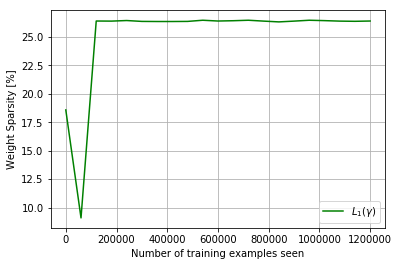

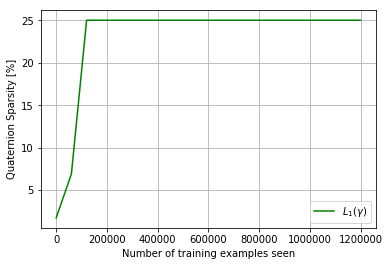

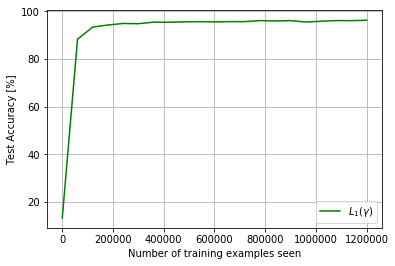

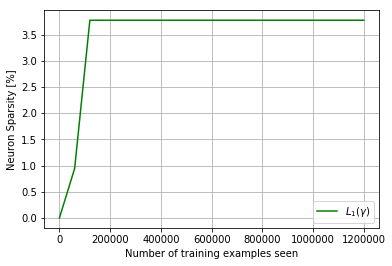

In [0]:
def compute_and_print_sparsityy(decimals=3, experiment_name=None, writer=None):

    network.eval()
  
    nonzero_weights, nonzero_quaternions, nonzero_neurons, number_of_quaternions, number_of_neurons= 0, 0, 0, 0, 0
    gamma_mask_list, weight_mask_list, quat_mask_list, neurons_mask_list = [], [], [], []
    
    for module in network.modules():
      
      #for param in module.parameters(recurse=False):
      #  weight_mask = torch.ge(torch.abs(param.detach()), 10**(-decimals)).float()
      #  weight_mask_list.append(weight_mask)
      
      if isinstance(module, QuaternionBatchNorm2d):
        nonzero_gamma = torch.ge(torch.abs(module.gamma), 10**(-decimals)).float()  # number of gamma that are > 0
        gamma_mask_list.append(nonzero_gamma)

      if isinstance(module, (QuaternionConv, QuaternionLinear, QuaternionTransposeConv)):

        number_of_quaternions += module.r_weight.numel()
        number_of_neurons += module.r_weight.shape[0]

        quat_norm = torch.sqrt(module.r_weight**2 + module.i_weight**2 + module.j_weight**2 + module.k_weight**2)
             
        weight_mask = torch.ge(torch.abs(module.r_weight), 10**(-decimals)).float() + torch.ge(torch.abs(module.i_weight), 10**(-decimals)).float() + torch.ge(torch.abs(module.j_weight), 10**(-decimals)).float() + torch.ge(torch.abs(module.k_weight), 10**(-decimals)).float()               
        quat_mask = torch.ge(torch.abs(quat_norm), 10**(-decimals)).float()
        quat_neurons_mask = (torch.sum(quat_mask.reshape(quat_mask.shape[0], -1), dim=1) > 0).float()
        
        weight_mask_list.append(weight_mask)
        quat_mask_list.append(quat_mask)
        neurons_mask_list.append(quat_neurons_mask)
        
        
    #if len(gamma_mask_list) > 0:
    #  gamma_mask_list.pop(0)  
    for index in range(len((neurons_mask_list))):
   
      gamma_mask = gamma_mask_list.pop(0).flatten() if len(gamma_mask_list) > 0 else torch.ones(neurons_mask_list[index].shape, device=device)

      if torch.sum(gamma_mask).item() == 0.:
        break
      else:
        weight_mask_list[index] = torch.sum(weight_mask_list[index].reshape(weight_mask_list[index].shape[0], -1), dim=1)
        quat_mask_list[index] = torch.sum(quat_mask_list[index].reshape(quat_mask_list[index].shape[0], -1), dim=1)

        nonzero_weights += torch.sum(weight_mask_list[index]*gamma_mask).item()
        nonzero_quaternions += torch.sum(quat_mask_list[index]*gamma_mask).item()
        nonzero_neurons += torch.sum(neurons_mask_list[index]*gamma_mask).item()
        
    
    weight_sparsity = (1 - nonzero_weights / count_trainable_parameters()) * 100
    quaternion_sparsity = (1 - nonzero_quaternions / number_of_quaternions) * 100 if use_quaternion_variant else 0
    neuron_sparsity = (1 - nonzero_neurons / number_of_neurons) * 100 
           
    if experiment_name is not None:
      experiments_results[experiment_name]['weight'].append(weight_sparsity)
      experiments_results[experiment_name]['quaternion'].append(quaternion_sparsity)
      experiments_results[experiment_name]['neuron'].append(neuron_sparsity)

    print('Checking sparsity...\nWeight sparsity: {:.2f}%'.format(weight_sparsity))
    print('Quaternion sparsity: {:.2f}%\n'.format(quaternion_sparsity)) if use_quaternion_variant else print()
    print('Neuron sparsity: {:.2f}%\n'.format(neuron_sparsity))
    
    if use_tensorboard and writer is not None:
      writer.add_scalars('Sparsity', { 'Weight sparsity [%]' : weight_sparsity,
                                       'Quaternion sparsity [%]' : quaternion_sparsity }, globaliter)



#@markdown ##Parameters and Hyper-parameters
n_epochs = 20 #@param {type: 'number'}
dataset = MNIST #@param ["CIFAR10", "MNIST"] {type:"raw"}
learning_rate = 0.001 #@param {type: 'number'}
loss_criterion = F.cross_entropy #@param ["F.cross_entropy", "F.nll_loss"] {type:"raw"}
batch_size_train = 400 #@param {type: 'number'}
batch_size_test = 1000 #@param {type: 'number'}
use_tensorboard = False #@param {type:"boolean"}

use_quaternion_variant = True

log_interval = 10
globaliter = 0 

#set_deterministic_environment()
use_beta=True   
      
class MNISTQConvNetBNA(nn.Module):  # Quaternion CNN for MNIST

    def __init__(self, use_qbn=True, gamma=1.0):
        super(MNISTQConvNetBNA, self).__init__()

        self.act_fn = F.relu
        self.use_qbn = use_qbn

        self.conv2 = QuaternionConv(4, 16, kernel_size=5, stride=1, padding=1)
        self.bn2 = QuaternionBatchNorm2d(16, gamma_init=gamma, beta_param=use_beta) if self.use_qbn else nn.BatchNorm2d(16)
        self.conv3 = QuaternionConv(16, 32, kernel_size=5, stride=1, padding=1)
        self.bn3 = QuaternionBatchNorm2d(32, gamma_init=gamma, beta_param=use_beta) if self.use_qbn else nn.BatchNorm2d(32)
        self.fc1 = QuaternionLinear(800, 40)

    def forward(self, x):
        x = self.act_fn(F.max_pool2d(self.conv2(x), 2))
        x = self.bn2(x)
        x = self.act_fn(F.max_pool2d(self.conv3(x), 2))
        x = self.bn3(x)
        x = x.view(-1, 800)
        x = self.act_fn(self.fc1(x))
        x = F.dropout(x, training=self.training)
        x = torch.reshape(x, (-1, 10, 4))
        x = torch.sum(torch.abs(x), dim=2)
        return F.log_softmax(x, dim=1)

    def network_type(self):
        return type(self).__name__


class CIFARQConvNetBNA(nn.Module):  # Quaternion CNN for CIFAR-10

    def __init__(self, use_qbn=True, gamma=1.0):
        super(CIFARQConvNetBNA, self).__init__()

        self.act_fn = F.relu
        self.use_qbn = use_qbn

        self.conv1 = QuaternionConv(4, 32, kernel_size=3, stride=1, padding=1)
        self.bn2 = QuaternionBatchNorm2d(32, gamma_init=gamma, beta_param=use_beta) if self.use_qbn else nn.BatchNorm2d(32)
        self.conv2 = QuaternionConv(32, 64, kernel_size=3, stride=1, padding=1)
        self.conv2_drop1 = nn.Dropout2d()
        self.bn3 = QuaternionBatchNorm2d(64, gamma_init=gamma, beta_param=use_beta) if self.use_qbn else nn.BatchNorm2d(64)
        self.conv3 = QuaternionConv(64, 128, kernel_size=3, stride=1, padding=1)
        self.bn4 = QuaternionBatchNorm2d(128, gamma_init=gamma, beta_param=use_beta) if self.use_qbn else nn.BatchNorm2d(128)
        self.conv4 = QuaternionConv(128, 256, kernel_size=3, stride=1, padding=1)
        self.conv4_drop2 = nn.Dropout2d()
        self.bn5 = QuaternionBatchNorm2d(256, gamma_init=gamma, beta_param=use_beta) if self.use_qbn else nn.BatchNorm2d(256)
        self.conv5 = QuaternionConv(256, 512, kernel_size=3, stride=1, padding=1)
        self.bn6 = QuaternionBatchNorm2d(512, gamma_init=gamma, beta_param=use_beta) if self.use_qbn else nn.BatchNorm2d(512)

        self.fc1 = QuaternionLinear(8192, 40)

    def forward(self, x):
        x = self.act_fn(F.max_pool2d(self.conv1(x), 2))
        x = self.bn2(x)
        x = self.act_fn(F.max_pool2d(self.conv2_drop1(self.conv2(x)), 2))
        x = self.bn3(x)
        x = self.act_fn(self.conv3(x))
        x = self.bn4(x)
        x = self.act_fn(F.max_pool2d(self.conv4_drop2(self.conv4(x)), 2))
        x = self.bn5(x)
        x = self.act_fn(self.conv5(x))
        x = self.bn6(x)
        x = x.view(-1, 8192)
        x = self.act_fn(self.fc1(x))
        x = F.dropout(x, training=self.training)
        x = torch.reshape(x, (-1, 10, 4))
        x = torch.sum(torch.abs(x), dim=2)
        return F.log_softmax(x, dim=1)

    def network_type(self):
        return type(self).__name__


input_expansion = 'zero_vector' if dataset == MNIST else 'rgb_vector'

train_counter, train_losses, test_counter, test_losses = [], [], [], []

writer = run_tensorboard_server() if use_tensorboard else None

batch_norm_experiments = {
    
  #'No reg' : {
  #    'network': MNISTQConvNetBNA(True, 0.4) if dataset == MNIST else CIFARQConvNetBNA(True, 0.4),
  #    'regularizer': 'None',
  #    'reg_factor': 0.01 if dataset == MNIST else 0.0003,#0.00015
  #    'latex_legend' : r'$No reg., \gamma=0.4$'
  #},
    
  'L1(gamma)' : {
      'network': MNISTQConvNetBNA(True, 0.1) if dataset == MNIST else CIFARQConvNetBNA(True, 0.1),
      'regularizer': 'L1_gamma',
      'reg_factor': 2.5 if dataset == MNIST else  0.09,
      'latex_legend' : r'$L_1(\gamma)$'
  },
    
  #'L1(w+gamma)' : {
  #    'network': MNISTQConvNetBNA(True, 0.1) if dataset == MNIST else CIFARQConvNetBNA(True, 0.1),
  #    'regularizer': 'L1',
  #    'reg_factor': 0.015 if dataset == MNIST else 0.00045,
  #    'latex_legend' : r'$L_1(w+\gamma)$'
  #},
    
  #'L1(w)' : {
  #    'network': MNISTQConvNetBNA(True, 0.1) if dataset == MNIST else CIFARQConvNetBNA(True, 0.1),
  #    'regularizer': 'L1_without_gamma',
  #    'reg_factor': 0.0027 if dataset == MNIST else 0.0003,
  #    'latex_legend' : r'$L_1(w), \gamma=0.1$'
  #},
  
  #'QBN+RQ' : {
  #    'network': MNISTQConvNetBNA(True, 0.1) if dataset == MNIST else CIFARQConvNetBNA(True, 0.1),
  #    'regularizer': 'RQ',
  #    'reg_factor': 0.008 if dataset == MNIST else 0.0004,
  #     'latex_legend' : r'$QBN+R_Q$'
  #},
    
  #'RQ' : {
  #    'network': MNISTQConvNet() if dataset == MNIST else CIFARQConvNet(),
  #    'regularizer': 'RQ',
  #    'reg_factor': 0.0075 if dataset == MNIST else 0.0000053,
  #    'latex_legend' : r'$R_Q$'
  #},
    
  #'QBN+RQL' : {
  #    'network': MNISTQConvNetBNA(True, 0.1) if dataset == MNIST else CIFARQConvNetBNA(True, 0.1),
  #    'regularizer': 'RQL_without_gamma',
  #    'reg_factor': 0.006 if dataset == MNIST else 0.00025,
  #    'latex_legend' : r'$QBN+R_{QL}$'
  #},
    
  #'RQL' : {
  #    'network': MNISTQConvNet() if dataset == MNIST else CIFARQConvNet(),
  #    'regularizer': 'RQL',
  #    'reg_factor': 0.0027 if dataset == MNIST else 0.0000034,
  #    'latex_legend' : r'$R_{QL}$'
  #},
    
}

experiments_results = {
  'No reg'      : { 'accuracy' : [], 'weight' : [], 'quaternion' : [], 'neuron' : [] }, 
  'L1(gamma)'   : { 'accuracy' : [], 'weight' : [], 'quaternion' : [], 'neuron' : [] }, 
  'L1(w+gamma)' : { 'accuracy' : [], 'weight' : [], 'quaternion' : [], 'neuron' : [] }, 
  'L1(w)'       : { 'accuracy' : [], 'weight' : [], 'quaternion' : [], 'neuron' : [] }, 
  'QBN+RQ'      : { 'accuracy' : [], 'weight' : [], 'quaternion' : [], 'neuron' : [] }, 
  'RQ'          : { 'accuracy' : [], 'weight' : [], 'quaternion' : [], 'neuron' : [] }, 
  'QBN+RQL'     : { 'accuracy' : [], 'weight' : [], 'quaternion' : [], 'neuron' : [] },  
  'RQL'         : { 'accuracy' : [], 'weight' : [], 'quaternion' : [], 'neuron' : [] } 
}


plot1, ax1 = plt.subplots()
plot2, ax2 = plt.subplots()
plot3, ax3 = plt.subplots()
plot4, ax4 = plt.subplots()
for index, (experiment_name, experiment_params) in enumerate(batch_norm_experiments.items()):
  
  network = experiment_params['network']
  regularizer = experiment_params['regularizer']
  regularization_factor = experiment_params['reg_factor']
  
  print('\nRegularizer: {} Reg. factor: {} '.format(experiment_name, regularization_factor))
   
  network = network.to(device)
  optimizer = optim.Adam(network.parameters(), lr=learning_rate)
  
  print('Device used: ' + device.type)
  print('Network variant: ' + network.network_type())
  print('Number of trainable parameters: {}\n'.format(count_trainable_parameters()))
  
  test_counter = []
  
  train_set, test_set = get_dataset()
  
  train(experiment_name, writer)
  
  print(experiment_name + ' weight')
  print(experiments_results[experiment_name]['weight'])
  print(experiment_name + ' quaternion')
  print(experiments_results[experiment_name]['quaternion'])
  print(experiment_name + ' neuron')
  print(experiments_results[experiment_name]['neuron'])
  print(experiment_name + ' accuracy')
  print(experiments_results[experiment_name]['accuracy'])
  
  ax1.plot(test_counter, smooth_data(test_counter, experiments_results[experiment_name]['weight']), color=colors[index])
  ax2.plot(test_counter, smooth_data(test_counter, experiments_results[experiment_name]['quaternion']), color=colors[index])
  ax3.plot(test_counter, smooth_data(test_counter, experiments_results[experiment_name]['accuracy']), color=colors[index])
  ax4.plot(test_counter, smooth_data(test_counter, experiments_results[experiment_name]['neuron']), color=colors[index])

labels = [item['latex_legend'] for item in batch_norm_experiments.values()]

ax1.legend(labels, loc='best')
ax2.legend(labels, loc='best')
ax3.legend(labels, loc='best')
ax4.legend(labels, loc='best')

ax1.set(xlabel='Number of training examples seen', ylabel='Weight Sparsity [%]')
ax2.set(xlabel='Number of training examples seen', ylabel='Quaternion Sparsity [%]')
ax3.set(xlabel='Number of training examples seen', ylabel='Test Accuracy [%]')
ax4.set(xlabel='Number of training examples seen', ylabel='Neuron Sparsity [%]')
plt.show()

## Test Deep Compression pipeline

In [0]:
#@markdown ##Parameters and Hyper-parameters

# PARAMETERS #

dataset = MNIST #@param ["CIFAR10", "MNIST"] {type:"raw"}
plot_curve = True #@param {type: 'boolean'}
use_tensorboard = False #@param {type:"boolean"}
log_interval = 10

# HYPER PARAMETERS #
n_epochs = 20 #@param {type: 'number'}
learning_rate = 0.002 #@param {type: 'number'}
loss_criterion = F.cross_entropy #@param ["F.cross_entropy", "F.nll_loss"] {type:"raw"}
batch_size_train = 400 #@param {type: 'number'}
batch_size_test = 1000 #@param {type: 'number'}
regularization_factor = 0.0075 #@param {type: 'number'}
regularizer = 'RQ' #@param ['None', 'L1', 'L2', 'RQ', 'RQL']

use_quaternion_variant = True
input_expansion = 'zero_vector' if dataset == MNIST else 'rgb_vector'

codebook = {
            'masks': [],
            'centroids': [],
            'labels': []
           }


def compress_network(use_quaternion_quantization=True, weight_sharing_bits=2, lr_tuning=0.0001):
  
  network.eval()
  
  torch.save(network.state_dict(), '../' + network.network_type() + '_1_after_training.pt')

  prune()
  test(n_epochs + 1)
  torch.save(network.state_dict(), '../' + network.network_type() + '_2_after_pruning.pt')
  
  if use_quaternion_quantization == True:
    apply_quaternion_weight_sharing(bits=weight_sharing_bits)
  else:
    apply_weight_sharing(bits=weight_sharing_bits)
    
  test(n_epochs + 2)
  torch.save(network.state_dict(), '../' + network.network_type() + '_3_after_weight_sharing.pt')
  
  start = time.time()
  fine_tuning_centroids(learning_rate_tuning=lr_tuning)
  print('elapsed time: ' + str(time.time()-start) + ' seconds')
  save_codebook()
  
  # huffman_encoding()
  # torch.save(network.state_dict(), '../' + network.network_type() + '_4_after_huffman.pt')


print('\n*** Quaternion NNs Compression Experiments ***\n')

writer = run_tensorboard_server() if use_tensorboard else None

if dataset == MNIST:
  network = MNISTQConvNet()
else:
  network = CIFARQConvNet()
        
network = network.to(device)
optimizer = optim.Adam(network.parameters(), lr=learning_rate)

print('Device used: ' + device.type)
print('Network variant: ' + network.network_type())
print('Number of trainable parameters: {}\n'.format(count_trainable_parameters()))

train_set, test_set = get_dataset()

train_counter, train_losses, test_counter, test_losses = [], [], [], []
globaliter = 0

if use_tensorboard:
  writer = run_tensorboard_server()
  
train(writer=writer)
compress_network()

sample_data, sample_targets = next(iter(test_set))
print('Evaluation of a random sample: {}'.format(inference(sample_data[0])))
show_image(sample_data[0], sample_targets[0])  # Show a random image from the test set

#if plot_curve:
#    plot_training_curve()



*** Quaternion NNs Compression Experiments ***

Device used: cuda
Network variant: MNISTQConvNet
Number of trainable parameters: 11688

Retrieve MNIST dataset...


Start training from MNIST training set to generate the model...
Epochs: 20
Learning rate: 0.002


Test set: Avg. loss: 2.3021, Accuracy: 979/10000 (9.79%)

Checking sparsity...
Weight sparsity: 18.30%
Quaternion sparsity: 1.72%

Train Epoch: 1 [0/60000 (0%)]	Loss: 2.302392
Train Epoch: 1 [4000/60000 (7%)]	Loss: 2.226390
Train Epoch: 1 [8000/60000 (13%)]	Loss: 1.572095
Train Epoch: 1 [12000/60000 (20%)]	Loss: 1.108619
Train Epoch: 1 [16000/60000 (27%)]	Loss: 0.975312
Train Epoch: 1 [20000/60000 (33%)]	Loss: 0.900868
Train Epoch: 1 [24000/60000 (40%)]	Loss: 0.815938
Train Epoch: 1 [28000/60000 (47%)]	Loss: 0.777590
Train Epoch: 1 [32000/60000 (53%)]	Loss: 0.849524
Train Epoch: 1 [36000/60000 (60%)]	Loss: 0.711237
Train Epoch: 1 [40000/60000 (67%)]	Loss: 0.829411
Train Epoch: 1 [44000/60000 (73%)]	Loss: 0.562371
Train Epoch: 1

IndexError: ignored